# Sentiment analysis

Sentiment analysis is a NLP technique to determine the sentiment of a sentence. In this implementation, we will focuse on determining the sentiment of the subject of the subject or object or the sentence.

Here I propose some possible sentences for our dataset, indicating where the meaning is encoded.

- Morose man cries. (morose)
- Irascible woman shouts. (irascible)
- Frightened woman shouts. (frightened)
- Joyful kid laughs. (joyful, laughs)
- Furious man snaps. (furious, snaps)
- Kid startles man. (startles)
- Woman grieves man. (grieves)
...


| Nouns | Verbs | Adjectives |
| --- | --- | --- |
| Man | cries | morose |
| Woman | laughs | irascible |
| Kid | shouts | frightened |
|  | snaps | cheerful |
|  | entertains | gloomy |
|  | grieves | furipus |
|  | startles | terrified |
|  | irritates |joyful|

The proposed vocabulary has 19 words and two different kind of sentences:
- Adj + Subject + Intransitive verb
- Subject + Transitive verb + Object

## 1. Create dataset

The first step is to create a dataset using the presented vocabulary. We have to store the words in DisCoPy's Word objects, encoding their meaning (name) and their grammar (codomain). Then, we introduce the grammar of the allowed sentences and create all the possible grammatical sentences. The next step is to assign a sentiment to each sentence. However, there are sentences that although they are grammatically correct, their meaning makes no sense, so we would have to remove them. 

### 1.1. Define the vocabulary

The first step to create a dataset is to define the words, their meaning and the word type. We have four three types of words: nouns, adjectives, verbs. We also distinguish two different types of verbs: transitive and intransitive. 

In [1]:
import numpy as np
import pickle

In [2]:
from discopy import Ty, Word # Import the classes for the type of word and for the word

s, n = Ty('s'), Ty('n') # Define the types s and n
nphr, adj, tv, iv, vphr = Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP')

# Define the words (notice that we include both meaning and grammar)

# nouns
man, woman, kid = Word('man', n), Word('woman', n), Word('kid', n)
# adjectives
morose, irascible = Word('morose', n @ n.l), Word('irascible', n @ n.l)
frightened, cheerful = Word('frightened', n @ n.l), Word('cheerful', n @ n.l)
gloomy, furious = Word('gloomy', n @ n.l), Word('furious', n @ n.l)
terrified, joyful = Word('terrified', n @ n.l), Word('joyful', n @ n.l)
# Intransitive verbs
cries, shouts = Word('cries', n.r @ s), Word('shouts', n.r @ s)
laughs, snaps = Word('laughs', n.r @ s), Word('snaps', n.r @ s)
# Transitive verbs
grieves, startles = Word('grieves', n.r @ s @ n.l), Word('startles', n.r @ s @ n.l)
entertains, irritates = Word('entertains', n.r @ s @ n.l), Word('irritates', n.r @ s @ n.l)

nouns = [man, woman, kid]
adjectives = [morose, irascible, frightened, cheerful, gloomy, furious, terrified, joyful]
int_verbs = [cries, shouts, laughs, snaps]
t_verbs = [grieves, startles, entertains, irritates]

vocab = nouns + int_verbs + t_verbs + adjectives

### 1.2. Define the grammar

In this dataset we are going to consider the following structures to construct the sentences:

- adj + noun + int. verb
- noun + t. verb + noun

- Intransitive sentence

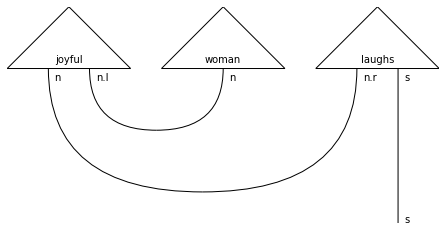

In [3]:
from discopy import Cup, Id, pregroup

grammar =  Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s)
sentence = joyful @ woman @ laughs >> grammar
pregroup.draw(sentence)

- Transitive sentence

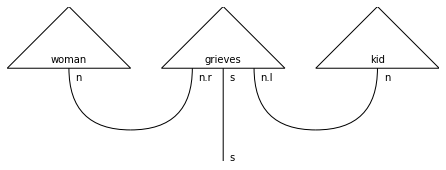

In [4]:
grammar =  Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = woman @ grieves @ kid >> grammar
pregroup.draw(sentence)

Now we have seen how the grammatical structure of each type of sentence is, so we are ready to obtain all the grammatical sentences that we can construct with them with the vocabulary that we are using. 

In [5]:
from discopy import Diagram
from discopy.grammar import draw

# Store the grammatical structures in a dictionary 

grammar_dict = {
    'ADJ_N_IV' : Id(n) @ Cup(n.l, n) @ Id(n.r @ s) >> Cup(n, n.r) @ Id(s) >> Id(s),
    'N_TV_N': Cup(n, n.r) @ Id(s) @ Cup(n.l, n)}
                                                                          

# Create parsing (grammatical analysis) dictionary where the grammatical sentences
# are the keys and the associated values are the diagrams (words + grammar)

data_psr = {}

# Intransitive sentences
parsing_int = {"{} {} {}.".format(adj, noun, int_verb): adj @ noun @ int_verb >> grammar_dict['ADJ_N_IV']
            for adj in adjectives for noun in nouns for int_verb in int_verbs}
sentences_int = list(parsing_int.keys())
for sentence in sentences_int:
    diagram = parsing_int[sentence]
    data_psr[sentence] = parsing_int[sentence]

# Transitive sentences
parsing_tra = {"{} {} {}.".format(subj, t_verb, obj):  subj @ t_verb @ obj >> grammar_dict['N_TV_N']
            for subj in nouns for t_verb in t_verbs for obj in nouns}
sentences_tra = list(parsing_tra.keys())
for sentence in sentences_tra:
    diagram = parsing_tra[sentence]
    data_psr[sentence] = parsing_tra[sentence]

Now, we have the dataset with the sentences and their corresponding meaning and grammar. The next step is to design the corresponding quantum circuits to determine the sentiment for each sentence. We are aiming to distinguish between four different emotions: happy (0), sad (1), angry (2), scared (3). However, some sentences of the dataset cannot be clearly classified according to this criteria (for example, 'Old man cries'). Therefore, the next step is to manually modify the dataset so all the sentences can be classified according to this criteria. In order to do that we will create a .txt file and assign the corresponding class to the viable sentences.

### 1.3. Process the data

In [6]:
with open('sentiment_basic.txt') as f:
    data = f.readlines()

In [7]:
labels_dict = {}
data_psr_dict = {}
sent_type = {}
for sentence in data:
    sentstr = sentence[:-7]
    if sentence[-6:-3] == 'int':
        diagram = parsing_int[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'int'
    elif sentence[-6:-3] == 'tra':
        diagram = parsing_tra[sentstr]
        data_psr_dict[sentstr] = diagram
        labels_dict[sentstr] = sentence[-2]
        sent_type[sentstr] = 'tra'

In [8]:
c0 = 0
c1 = 0
c2 = 0
c3 = 0
for value in labels_dict.values():
    if value == '0':
        c0 +=1
    elif value == '1':
        c1 += 1
    elif value == '2':
        c2 += 1
    elif value == '3':
        c3 += 1
print('Number of elements for each sentiment')
print('Happy: ', c0)
print('Sad: ', c1)
print('Angry: ', c2)
print('Scared: ', c3)
print('Total', len(data_psr_dict))

Number of elements for each sentiment
Happy:  27
Sad:  21
Angry:  26
Scared:  21
Total 95


Now we have our dataset! The only problem left is the fact that the cups used in the diagrams are too resource consumming. Luckily, it is possible to remove them by transforming the states into effects (we are just doing this with the nouns as in https://github.com/CQCL/qnlp_lorenz_etal_2021_resources). Let us see some examples

- Intransitive sentence

In [9]:
from discopy import Cap, Box

woman2 = Box('woman', n.l, Ty())
words_new = (Cap(n, n.l)) >> (joyful @ Id(n) @ woman2 @ laughs)
sentence = words_new >> grammar_dict['ADJ_N_IV']
sentence = sentence.normal_form()

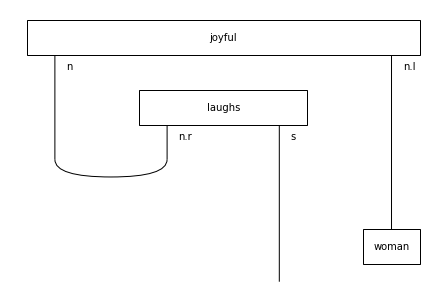

In [10]:
sentence.draw()

- Transitive sentence

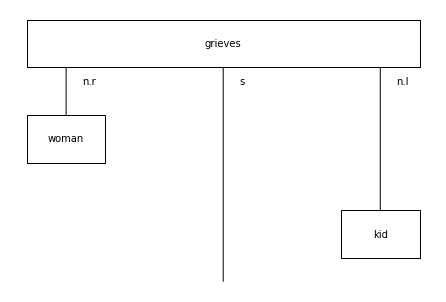

In [11]:
woman2 = Box('woman', n.r, Ty())
kid2 = Box('kid', n.l, Ty())
words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (woman2 @ Id(n) @ grieves @ Id(n) @ kid2)
sentence = words_new >> grammar_dict['N_TV_N']
sentence = sentence.normal_form()
sentence.draw()

Let us apply this to our entire dataset.

In [12]:
data_new_psr_dict = {}
for sentstr in data_psr_dict.keys():
    num_words = len(sentstr.split(' '))
    words = data_psr_dict[sentstr].boxes[:num_words]
    if sent_type[sentstr] == 'int':
        noun = Box(words[1].name, n.l, Ty())
        words_new = (Cap(n, n.l)) >> (words[0] @ Id(n) @ noun @ words[2])
        sentence = words_new >> grammar_dict['ADJ_N_IV']
        data_new_psr_dict[sentstr] = sentence.normal_form()
    elif sent_type[sentstr] == 'tra':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
        sentence = words_new >> grammar_dict['N_TV_N']
        data_new_psr_dict[sentstr] = sentence.normal_form()

The final step before the implementation of the quantum circuit is to redefine the vocabulary according to the new domain and codamain for the nouns as effects.

In [13]:
vocab_psr = []
for word in vocab:
    if word.cod == Ty('n'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

## 2. Create quantum circuit

Once the dataset and its corresponding diagrams are created, the next step is to construct the variational quantum circuits associated with them. In order to do that, we will use different ansätze depending on the type of the word that we want to represent. In this case we only have two types of words, nouns and verbs. Both types will have associated 2 qubits (as we have four sentiments, we need 4 quantum states to encode the result of the classification). Moreover, we will also distinguish between states and effects when constructing the ansätze.

In [14]:
from discopy.quantum import Ket, IQPansatz, Bra, qubit
from discopy.quantum.circuit import Functor, Id
from discopy.quantum.circuit import Circuit
from functools import reduce, partial

q_s = 2 # number of qubits for type s (sentence)
q_n = 2 # number of qubits for type n (noun)
depth = 1 # depth of the IQPansatz

# Define the dimensions of the objects of the circuit functor
ob = {s: q_s, n: q_n}                          
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   

# Define the ansätze for states and effects
def ansatz_state(state, params):
    arity = sum(ob[Ty(factor.name)] for factor in state.cod) 
    return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params): 
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

# Construct the circuit functor
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})
    return Functor(ob_cqmap, ar)

In [15]:
#*****************************************************
# Functions to deal with the parametrisation
#*****************************************************

def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            parshapes.append((depth, arity-1))
    return parshapes

def randparams(par_shapes):
    params = np.array([]) 
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(np.random.rand(*par_shapes[i])))) # np.ravel flattens an array
    return params 

def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

In [16]:
#****************************************
# Parameters of the current model
#****************************************

par_shapes = paramshapes(vocab_psr)
rand_unshaped_pars = randparams(par_shapes)
rand_shaped_pars = reshape_params(rand_unshaped_pars, par_shapes)

print('Number of parameters:    ', len(rand_unshaped_pars))

Number of parameters:     59


In [ ]:
# Print the quantum circuit for each sentence

func = F(rand_shaped_pars)

for sentstr in data_new_psr_dict:
    print(sentstr)
    print(data_new_psr_dict[sentstr])
    func(data_new_psr_dict[sentstr]).draw(draw_box_labels=True, figsize=(5, 5))

## 3. Create training and test dataset

The next step is to divide our dataset into training and test data, so we can perform the classification using a supervised quantum machine learning technique. We need the data, which are the quantum circuits associated to each sentences, and the labels, that encode the sentiment. In this case the labels are the four possible quantum states that can be obtained from measuring a 2-qubit quantum circuit:

- Happy: $ \ 0 \ \rightarrow \ |00\rangle = [1,0,0,0] \ \rightarrow \ p_{00}=1$,
- Sad: $ \ 1 \ \rightarrow \ |01\rangle = [0,1,0,0] \ \rightarrow \ p_{01}=1$,
- Angry: $ \ 2 \ \rightarrow \ |10\rangle = [0,0,1,0] \ \rightarrow \ p_{10}=1$,
- Scared: $ \ 3 \ \rightarrow \ |11\rangle = [0,0,0,1] \ \rightarrow \ p_{11}=1$.

In [18]:
from sklearn.model_selection import train_test_split

psr_diagrams = []
psr_diagrams_dict = {}
psr_labels = []
sentences = []

for sentstr in data_new_psr_dict.keys():
    sentences.append(sentstr)
    diagram = data_new_psr_dict[sentstr]
    psr_diagrams.append(diagram)
    psr_diagrams_dict[sentstr] = diagram
    if labels_dict[sentstr] == '0':
        label = np.array([1,0,0,0])
    elif labels_dict[sentstr] == '1':
        label = np.array([0,1,0,0])
    elif labels_dict[sentstr] == '2':
        label = np.array([0,0,1,0])
    elif labels_dict[sentstr] == '3':
        label = np.array([0,0,0,1])
    psr_labels.append(label)

train_data_psr, test_data_psr, train_labels, test_labels = \
    train_test_split(psr_diagrams, psr_labels, test_size=0.25, random_state=42)
train_sent, test_sent, train_labels_sent, test_labels_sent = \
    train_test_split(sentences, psr_labels, test_size=0.25, random_state=42)

I'm not sure how to make the statevector simulator and the qasm simulator work with the measurements made in DisCoPy.

In [19]:
# If we want to work with Qiskit circuits

from pytket.extensions.qiskit import tk_to_qiskit
from discopy.quantum.tk import to_tk

qiskit_train_circuits = []
for diagram in train_data_psr:
    circuit = func(diagram)
    pytket_circuit = circuit.to_tk()
    qiskit_train_circuits.append(tk_to_qiskit(pytket_circuit))
    
qiskit_test_circuits = []
for diagram in test_data_psr:
    circuit = func(diagram)
    pytket_circuit = circuit.to_tk()
    qiskit_test_circuits.append(tk_to_qiskit(pytket_circuit))

## 4. Optimization functions

The next step is to define the functions that we will use for the optimization. We will resort to a classical optimizer to perform this variational optimization, more concretely the SPSA. The cost function for this algorithm is the cross entropy, which is used to measure the distance between two probability distributions. For two probability distributions $S$ and $L$, the cross entropy $D$ is defined as

\begin{equation}
    D(S,L) = - \sum_i L_i \log (S_i).
\end{equation}

In our problem we have the labels that account for the ideal probability distribution $L$ associated to each sentiment, while the output of the variational algorithm is the distribution $S$.

Now we are going to define a function to compute the cross entropy for our problem, as well as the probabilities associated to each quantum circuit and the train and test errors.

In [20]:
from pytket.extensions.qiskit import AerBackend
from discopy.quantum import Measure
backend = AerBackend()
max_n_shots = 8192  # maximum shots possible

In [21]:
def get_probs(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    train_circuits = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr]
    results = Circuit.eval(*train_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res.flatten() / np.sum(res) for res in results_tweaked]
    return pred_labels_distrs

def get_cost(pred_labels_distrs):
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    return -1 / len(train_data_psr) * np.sum(cross_entropies)

def get_train_error(pred_labels_distrs):
    correct = 0
    assert len(pred_labels_distrs[0].flatten()) == 4 
    for i, res in enumerate(pred_labels_distrs):
        pred_result = np.argmax(res.flatten())
        train_result = np.argmax(train_labels[i])
        if train_result == pred_result:
            correct += 1
    return 100 - correct * 100 / len(train_data_psr)

def get_test_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    test_circuits = [(func(circ) >> Measure() @ Measure()) for circ in test_data_psr]
    results = Circuit.eval(*test_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    assert len(results_tweaked[0].flatten()) == 4
    correct = 0
    pred_labels = []
    for i, res in enumerate(results_tweaked):
        pred_result = np.argmax(res.flatten())
        test_result = np.argmax(test_labels[i])
        pred_labels.append(pred_result)
        if test_result == pred_result:
            correct += 1
    return 100 - correct * 100 / len(test_data_psr), pred_labels

Once we have the cost function, we define a customized SPSA optimizer suitable for our task.

In [22]:
#**********************************************************************************
# Minimization algorithm
#**********************************************************************************

# This is building on the minimizeSPSA function from the noisyopt package (https://github.com/andim/noisyopt);
# here only adjusted for our purposes. As this is an example notebook for a final run of the experiment
# the dev set is not used here.

def my_spsa(get_probs, get_cost, get_train_error, get_test_error, x0,
            bounds=None, niter=100, shots=1024, a=1.0, c=1.0, alpha=0.602, gamma=0.101,
            print_iter=False, correct_func_value=True,
            filename='spsa_output', iters_selected=[]):
    A = 0.01 * niter
    N = len(x0)
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    param_history = []
    func_history = []
    error_history = []
    pred_label_history = []
    pred_labels_test_error = dict()
    test_error_list = []
    x = x0    
    
    # Loop over iterations
    for k in range(niter):
        if print_iter:
            print('-------------', '\n', 'iteration: ', k, sep='')
        start = time()
        
        # determine stepping parameters
        ak = a/(k+1.0+A)**alpha
        ck = c/(k+1.0)**gamma
        delta = np.random.choice([-1, 1], size=N)
        
        # move in + direction from previous x
        xplus = project(x + ck*delta)        
        if print_iter:
            print('Call for xplus')
        results_tweaked_plus = get_probs(xplus)
        funcplus = get_cost(results_tweaked_plus)
        
        # move in - direction from previous x
        xminus = project(x - ck*delta)
        if print_iter:
            print('Call for xminus')
        results_tweaked_minus = get_probs(xminus)
        funcminus = get_cost(results_tweaked_minus)
        
        # new step
        grad = (funcplus - funcminus) / (xplus-xminus)
        x = project(x - ak*grad)
        param_history.append(x)
        
        # determine current func and error
        if correct_func_value or k == (niter - 1):  # In order to save time the cost at x is only evaluated for final step
            if print_iter:
                print('Call for current_func_value')
            results_tweaked = get_probs(x)
            current_func_value = get_cost(results_tweaked)
            error = get_train_error(results_tweaked)
            pred_label_history.append(results_tweaked)
        else:
            current_func_value = funcplus
            error = get_train_error(results_tweaked_plus)
            pred_label_history.append(results_tweaked_plus)
        
        # calculate test error if a 'selected iteration' 
        if k in iters_selected:
            print('Calculate test error for iteration:', k)
            res = get_test_error(x)
            test_error_list.append(res[0])
            pred_labels_test_error.update({k: res[1]})
        
        func_history.append(current_func_value)
        error_history.append(error)

        # save to file
        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history,
            'predlabel_history': pred_label_history,
            'iters_selected': iters_selected,
            'test_error_list': test_error_list,
            'pred_labels_test_error': pred_labels_test_error
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        if print_iter:
            print('Time taken for this iteration: ', time() - start)
    return param_history, func_history, error_history, test_error_list

Finally, we can run the optimizer and obtain the results.

In [ ]:
#************************************
# Quantum run: training and error calculation
#************************************
from time import time

bounds = [[0.0, 1.0] for ii in range(len(rand_unshaped_pars))]
c_fix = 0.1   
a_est = 0.015  

n_runs = 1
niter = 1000
param_histories = []
cost_histories = np.zeros((n_runs, niter))
error_train_histories = np.zeros((n_runs, niter))

# For test error calculation (for reasons of time cost not for all iterations)
iters_selected = [(i+1)*10-1 for i in range(int(niter/10))]
iters_selected.insert(0, 0)
error_test_histories = np.zeros((n_runs, len(iters_selected)))

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    rand_unshaped_pars = randparams(par_shapes)
    start = time()
    res = my_spsa(get_probs, get_cost, get_train_error, get_test_error, rand_unshaped_pars,
                  bounds=bounds, niter=niter, shots=1, a=a_est, c=c_fix,
                  print_iter=True, correct_func_value=False, filename=('MC_task_SPSAOutput_Run' + str(i)),
                  iters_selected=iters_selected)
    param_histories.append(res[0])   
    cost_histories[i, :] = res[1]
    error_train_histories[i, :] = res[2]
    error_test_histories[i, :] = res[3]
    print('run', i+1, 'done')
    print('Time taken: ', time() - start)

---------------------------------
Start run  1
-------------
iteration: 0
Call for xplus
Call for xminus
Calculate test error for iteration: 0
Time taken for this iteration:  14.0407555103302
-------------
iteration: 1
Call for xplus
Call for xminus
Time taken for this iteration:  11.949981451034546
-------------
iteration: 2
Call for xplus
Call for xminus
Time taken for this iteration:  12.281237840652466
-------------
iteration: 3
Call for xplus
Call for xminus
Time taken for this iteration:  11.726755619049072
-------------
iteration: 4
Call for xplus
Call for xminus
Time taken for this iteration:  11.525566339492798
-------------
iteration: 5
Call for xplus
Call for xminus
Time taken for this iteration:  11.82399606704712
-------------
iteration: 6
Call for xplus
Call for xminus
Time taken for this iteration:  12.019760608673096
-------------
iteration: 7
Call for xplus
Call for xminus
Time taken for this iteration:  11.080523014068604
-------------
iteration: 8
Call for xplus
Call

In [ ]:
#****************************************************
# Averaging
#****************************************************

# In case N_runs > 1, one may want to calculate cost and errors averaged over several runs...

# In this example notebook however not done, hence:
cost_history = cost_histories[0, :]
error_train_history = error_train_histories[0, :]
error_test_history = error_test_histories[0, :]

In [ ]:
#****************************************************
# Summary plot
#****************************************************
from matplotlib import pyplot as plt

plt.rcParams.update({"text.usetex": True})
fig, ax1 = plt.subplots(figsize=(13, 8))

ax1.plot(range(len(cost_history)), cost_history, '-k', markersize=4, label='cost')
ax1.set_ylabel(r"Cost", fontsize='x-large')
ax1.set_xlabel(r"SPSA~iterations", fontsize='x-large')
ax1.legend(loc='upper center', fontsize='x-large')

ax2 = ax1.twinx()
ax2.set_ylabel(r"Error in \%", fontsize='x-large')
ax2.plot(range(len(error_train_history)), error_train_history, '-g', markersize=4, label='training error')
ax2.plot(iters_selected, error_test_history, 'xb', markersize=7, label='testing error')
ax2.legend(loc='upper right', fontsize='x-large')

plt.title('MC task, quantum run -- results', fontsize='x-large')
plt.savefig('MC_task_Results.png', dpi=300, facecolor='white')  
plt.show()

In [ ]:
final_params = res[0][-1]
func = F(reshape_params(final_params, par_shapes))
final_train_circuits = [(func(circ) >> Measure() @ Measure()) for circ in train_data_psr]
final_test_circuits = [(func(circ) >> Measure() @ Measure()) for circ in test_data_psr]
train_results = Circuit.eval(*final_train_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
test_results = Circuit.eval(*final_test_circuits, backend=backend, n_shots=max_n_shots, compilation=backend.default_compilation_pass(2))
train_results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in train_results]
test_results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in test_results]
pred_train_results = [res.flatten() / np.sum(res) for res in train_results_tweaked]
pred_test_results = [res.flatten() / np.sum(res) for res in test_results_tweaked]

In [ ]:
correct = 0
for i, res in enumerate(pred_train_results):
    pred_result = np.argmax(res.flatten())
    train_result = np.argmax(train_labels[i])
    print(train_sent[i])
    #print(res.flatten())
    print(pred_result,train_result)
    if train_result == pred_result:
        correct += 1
    #print(f'Result: {train_array, train_result}, Predicted result: {res, pred_result}')
print('Correct predictions (train):',correct/len(train_results_tweaked))

In [ ]:
correct = 0
for i, res in enumerate(test_results_tweaked):
    pred_result = np.argmax(res.flatten())
    test_result = np.argmax(test_labels[i])
    if test_result == pred_result:
        correct += 1
print('Correct predictions (test):',correct/len(test_results_tweaked))